In [2]:
import matplotlib.pyplot as plt
import pandas as pd

tracks=pd.read_csv("fma-rock-vs-hiphop.csv")
echonest_metrics=pd.read_json("echonest-metrics.json",precise_float=True)
print(echonest_metrics.columns)

echo_tracks=echonest_metrics.merge(tracks[['track_id','genre_top']],on='track_id')
echo_tracks.info()

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [3]:

numeric_columns=echo_tracks.select_dtypes(include=['number'])

corr_matrics=numeric_columns.corr()
corr_matrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [4]:
from sklearn.model_selection import train_test_split
features = echo_tracks.drop(['genre_top','track_id'],axis=1).values
labels=echo_tracks['genre_top'].values

train_features,test_features,train_labels,test_labels=train_test_split(features,labels,random_state=10)

In [5]:
from sklearn.preprocessing import StandardScaler

scalar= StandardScaler()

scaled_train_features=scalar.fit_transform(train_features)
scaled_test_features=scalar.transform(test_features)

Text(0.5, 0, 'Principle Component #')

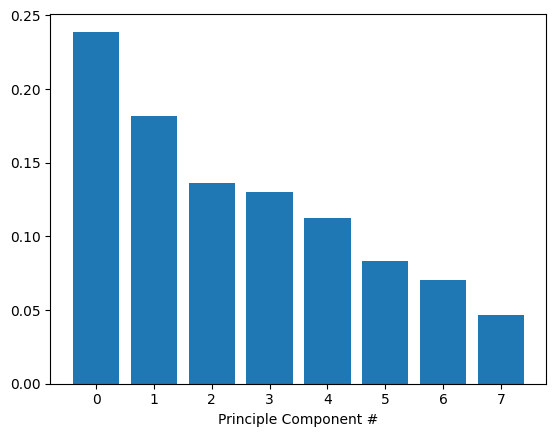

In [6]:

from sklearn.decomposition import PCA 

pca=PCA()

pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

fig, ax=plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principle Component #')

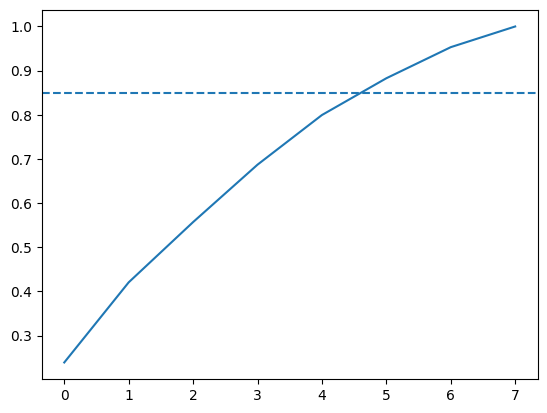

In [7]:
import numpy as np
cum_exp_variance = np.cumsum(exp_variance)

fix, ax=plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85,linestyle='--')

In [8]:
pca=PCA(n_components=6)

train_pca=pca.fit_transform(scaled_train_features)
test_pca=pca.transform(scaled_test_features)

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier(random_state=10)
tree.fit(train_pca,train_labels)

pred_labels_tree=tree.predict(test_pca)
print(pred_labels_tree)

['Rock' 'Rock' 'Rock' ... 'Hip-Hop' 'Rock' 'Rock']


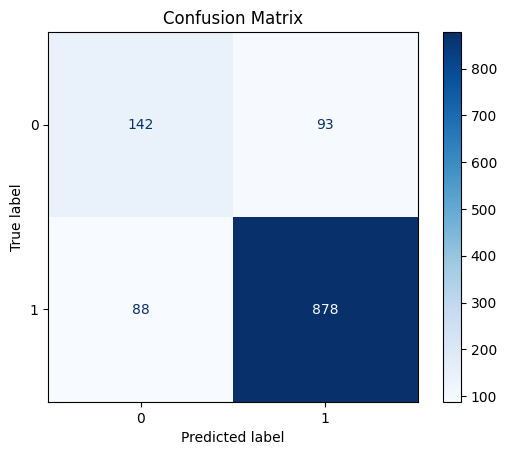

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(test_labels,pred_labels_tree)

disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(random_state=10)
logreg.fit(train_pca,train_labels)
pred_labels_logit=logreg.predict(test_pca)

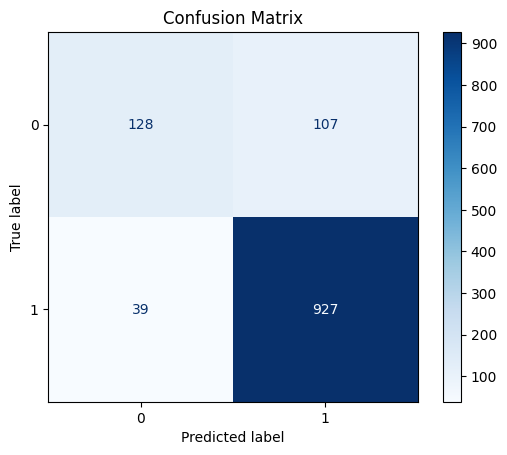

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(test_labels,pred_labels_logit)

disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report

class_rep_tree=classification_report(test_labels,pred_labels_tree)
class_rep_log=classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n",class_rep_tree)
print("Logistic Regression: \n",class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.62      0.60      0.61       235
        Rock       0.90      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.76      0.76      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [14]:
hop_only=echo_tracks.loc[echo_tracks['genre_top']=='Hip-Hop']
rock_only=echo_tracks.loc[echo_tracks['genre_top']=='Rock']

rock_only=rock_only.sample(hop_only.shape[0],random_state=10)

rock_hop_bal=pd.concat([rock_only,hop_only])

features=rock_hop_bal.drop(['genre_top','track_id'],axis=1)
labels=rock_hop_bal['genre_top']

train_features,test_features,train_labels,test_labels=train_test_split(features,labels,random_state=10)

train_pca=pca.fit_transform(scalar.fit_transform(train_features))
test_pca=pca.transform(scalar.transform(test_features))

In [15]:
tree=DecisionTreeClassifier(random_state=10)

tree.fit(train_pca,train_labels)
pred_labels_tree=tree.predict(test_pca)

logreg=LogisticRegression()
logreg.fit(train_pca,train_labels)
pred_labels_logit=logreg.predict(test_pca)

print("Decision Tree: \n",classification_report(test_labels,pred_labels_tree))
print("Logistic RegressionL \n",classification_report(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.83      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic RegressionL 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



In [16]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

tree_pipe=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=6)),('tree',DecisionTreeClassifier(random_state=10))])
logreg_pipe=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=6)),('logreg',LogisticRegression(random_state=10))])

kf=KFold(10)

tree_score=cross_val_score(tree_pipe,features,labels,cv=kf)
logit_score=cross_val_score(logreg_pipe,features,labels,cv=kf)

print('Decision Tree:',tree_score.mean(),'Logistic Regression:',logit_score.mean())

Decision Tree: 0.7598901098901099 Logistic Regression: 0.782967032967033


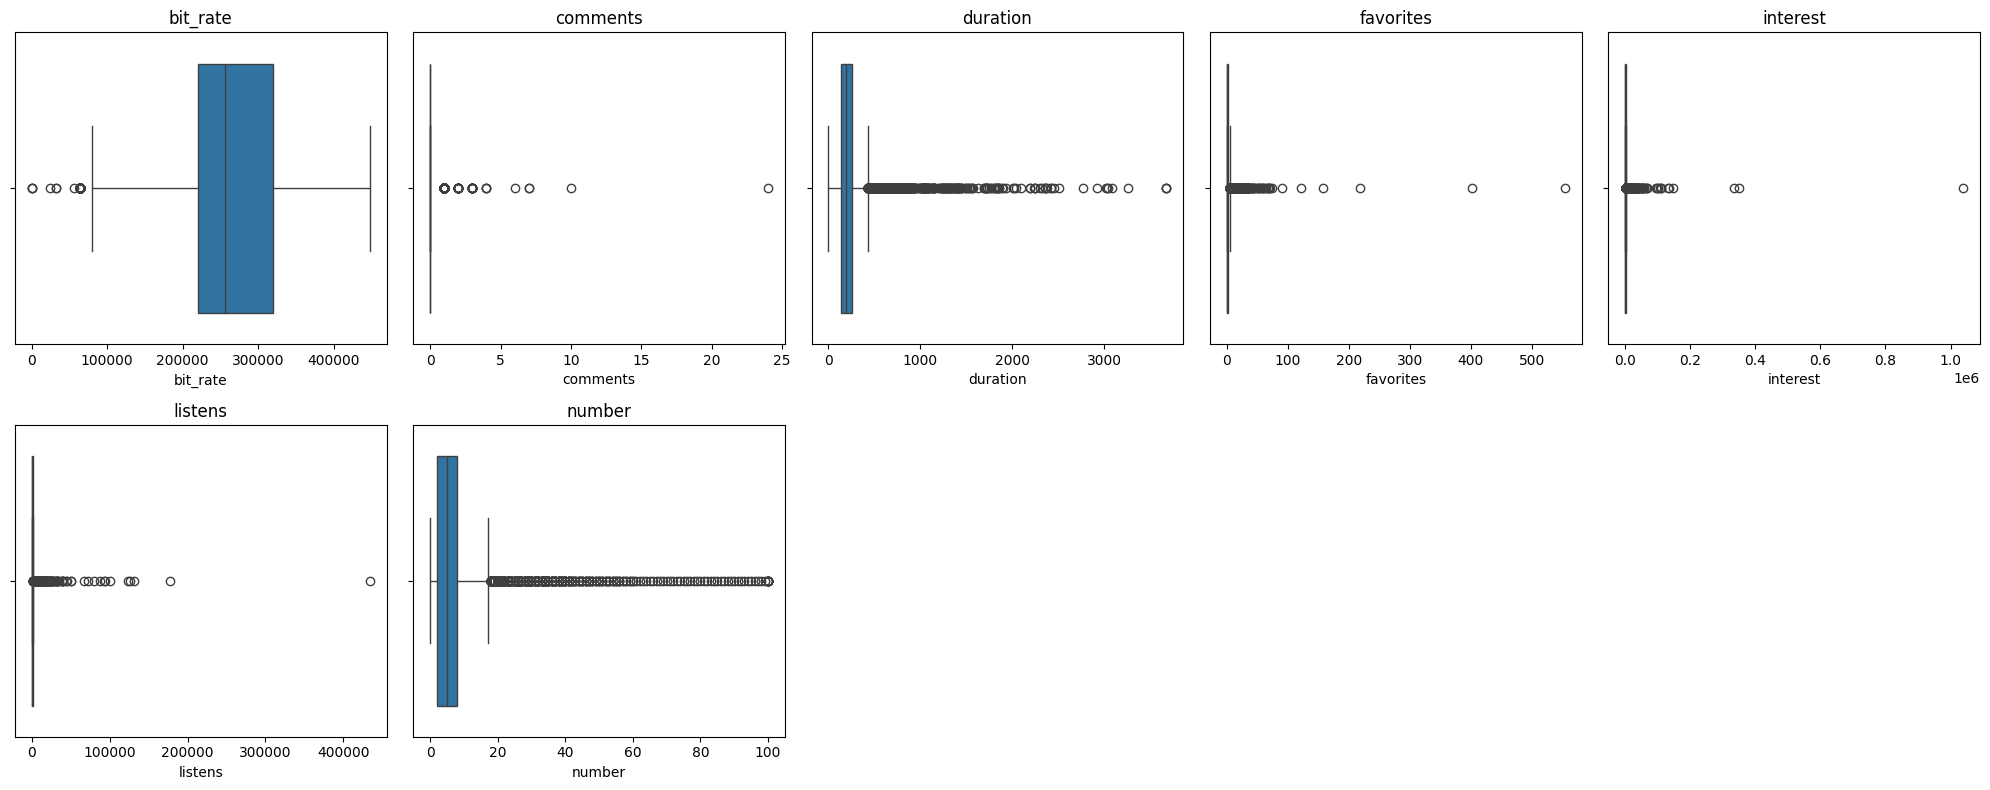

In [17]:
import seaborn as sns 
df=pd.read_csv("fma-rock-vs-hiphop.csv")

numeric_features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['track_id'])

num_features = len(numeric_features.columns)
num_cols = 5
num_rows = int(np.ceil(num_features / num_cols))

plt.figure(figsize=(num_cols * 4, num_rows * 4))

for i, column in enumerate(numeric_features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(x=numeric_features[column])
    plt.title(column)

plt.tight_layout()
plt.show()